In [31]:
import os
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === 设置代理（可选）===
os.environ['HTTP_PROXY'] = 'http://127.0.0.1:7890'
os.environ['HTTPS_PROXY'] = 'http://127.0.0.1:7890'

# === Step 1: 获取数据 ===
def get_price_data(ticker, start='2023-01-01', end='2024-01-01'):
    df = yf.download(ticker, start=start, end=end)
    df = df[['Open', 'Close']].dropna()
    df.columns = ['open', 'close']
    return df

# === Step 2: 生成交易信号并构建持仓状态 ===
def generate_signals_v1(df, short_window=5, long_window=10):
    """
    v1: buy & sell base solely on ma_short and ma_long
    """
    df['ma_short'] = df['close'].rolling(short_window).mean()
    df['ma_long'] = df['close'].rolling(long_window).mean()

    # 构建交易信号
    df['signal'] = 0
    df.loc[df['ma_short'] > df['ma_long'], 'signal'] = 1   # 买入信号
    df.loc[df['ma_short'] < df['ma_long'], 'signal'] = -1  # 卖出信号

    # 构建持仓状态
    df['position'] = 0
    current_position = 0
    for i in range(1, len(df)):
        if current_position == 0 and df.iloc[i]['signal'] == 1:
            current_position = 1  # 建仓
        elif current_position == 1 and df.iloc[i]['signal'] == -1:
            current_position = 0  # 清仓
        df.at[df.index[i], 'position'] = current_position

    return df

def generate_signals_v2(df, short_window=5, long_window=10, take_profit=0.1, stop_loss=0.01):
    """
    v2: add profit & loss into buy/sell signal
    """
    df = df.copy()
    df['ma_short'] = df['close'].rolling(short_window).mean()
    df['ma_long'] = df['close'].rolling(long_window).mean()

    df['signal'] = 0
    df['position'] = 0
    df['entry_price'] = None
    df['max_price_since_entry'] = None

    in_position = False         # 在场内
    entry_price = 0.0
    max_price = 0.0

    for i in range(1, len(df)):
        price = df.iloc[i]['close']
        ma_short = df.iloc[i]['ma_short']
        ma_long = df.iloc[i]['ma_long']

        if not in_position:
            if ma_short > ma_long:
                in_position = True
                entry_price = price
                max_price = price
                df.at[df.index[i], 'signal'] = 1  # 买入
                df.at[df.index[i], 'entry_price'] = entry_price
                df.at[df.index[i], 'position'] = 1
        else:
            max_price = max(max_price, price)
            return_rate = (price - entry_price) / entry_price
            drawdown = (max_price - price) / max_price if max_price > 0 else 0

            # 卖出条件：止盈 或 止损 或 均线死叉
            if return_rate >= take_profit or drawdown >= stop_loss or ma_short < ma_long:
                in_position = False
                df.at[df.index[i], 'signal'] = -1  # 卖出
                df.at[df.index[i], 'position'] = 0
            else:
                df.at[df.index[i], 'position'] = 1
                df.at[df.index[i], 'entry_price'] = entry_price
                df.at[df.index[i], 'max_price_since_entry'] = max_price

    return df


# === Step 3: 回测逻辑（次日开盘交易）===
def run_backtest(df):
    df['next_open'] = df['open'].shift(-1)
    df['strategy_return'] = 0.0
    position = 0
    entry_price = 0.0

    for i in range(1, len(df) - 1):  # 注意避免越界
        # 建仓
        if df.iloc[i - 1]['position'] == 0 and df.iloc[i]['position'] == 1:
            entry_price = df.iloc[i + 1]['open']  # 用下一个交易日的 open 作为买入价
            entry_date = df.index[i + 1]
            position = 1

        # 平仓
        elif df.iloc[i - 1]['position'] == 1 and df.iloc[i]['position'] == 0:
            exit_price = df.iloc[i + 1]['open']
            exit_date = df.index[i + 1]
            ret = (exit_price - entry_price) / entry_price

            # 将整个持仓期间的收益平均分配（可选，或只记录在卖出那天）
            df.at[exit_date, 'strategy_return'] = ret
            position = 0

    df['return'] = df['next_open'].pct_change()  # 还是可以对比 benchmark
    df['cum_return'] = (1 + df['strategy_return'].fillna(0)).cumprod()
    df['cum_benchmark'] = (1 + df['return'].fillna(0)).cumprod()
    return df

# === Step 4: 绩效评估 ===
def evaluate_performance(df):
    daily_return = df['strategy_return'].dropna()
    ann_return = df['cum_return'].iloc[-1] ** (252 / len(daily_return)) - 1
    ann_vol = daily_return.std() * (252 ** 0.5)
    sharpe = ann_return / ann_vol if ann_vol != 0 else 0
    max_drawdown = (df['cum_return'] / df['cum_return'].cummax() - 1).min()
    
    return {
        'Annual Return': round(ann_return, 4),
        'Sharpe Ratio': round(sharpe, 2),
        'Max Drawdown': round(max_drawdown, 4)
    }

# === Step 5: 绘图 ===
def plot_trade_signals(df):
    plt.figure(figsize=(12, 6))

    # 价格和均线
    plt.plot(df['close'], label='Close Price', color='black', linewidth=1)
    plt.plot(df['ma_short'], label='MA Short', color='blue', linestyle='--', linewidth=1)
    plt.plot(df['ma_long'], label='MA Long', color='orange', linestyle='--', linewidth=1)

    # 找到买卖点的时间戳和价格
    buy_signals = df[(df['position'] == 1) & (df['position'].shift(1) == 0)]
    sell_signals = df[(df['position'] == 0) & (df['position'].shift(1) == 1)]

    # 红绿色竖线绘制
    for idx in buy_signals.index:
        plt.axvline(x=idx, color='green', linestyle='-', linewidth=1, alpha=0.6, label='Buy Signal' if idx == buy_signals.index[0] else "")

    for idx in sell_signals.index:
        plt.axvline(x=idx, color='red', linestyle='-', linewidth=1, alpha=0.6, label='Sell Signal' if idx == sell_signals.index[0] else "")

    # 图例与样式
    plt.title('Trade Points with Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("../data/img.svg", format="svg")
    plt.show()




# === 主程序入口 ===
if __name__ == "__main__":
    ticker = "000300.SS"  # 可替换为其他代码，如 "AAPL", "SPY"
    df = get_price_data(ticker)

    # df = generate_signals_v1(df, short_window=1, long_window=5)
    df = generate_signals_v2(df, short_window=1, long_window=10)
    df = run_backtest(df)

    performance = evaluate_performance(df)
    for k, v in performance.items():
        print(f"{k}: {v}")

    plot_trade_signals(df)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_21240\1825634824.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


KeyError: 'price'

In [6]:
ticker = "000300.SS"  # 可替换为其他代码，如 "AAPL", "SPY"
df = get_price_data(ticker)
print(df)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21240\2627736500.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed

                   open        close
Date                                
2021-03-11  5024.560059  5128.220215
2021-03-12  5153.669922  5146.379883
2021-03-15  5116.120117  5035.540039
2021-03-16  5054.410156  5079.359863
2021-03-17  5062.770020  5100.859863
...                 ...          ...
2025-06-24  3862.389893  3904.030029
2025-06-25  3907.070068  3960.070068
2025-06-26  3953.159912  3946.020020
2025-06-27  3949.790039  3921.760010
2025-06-30  3920.320068  3936.080078

[1043 rows x 2 columns]


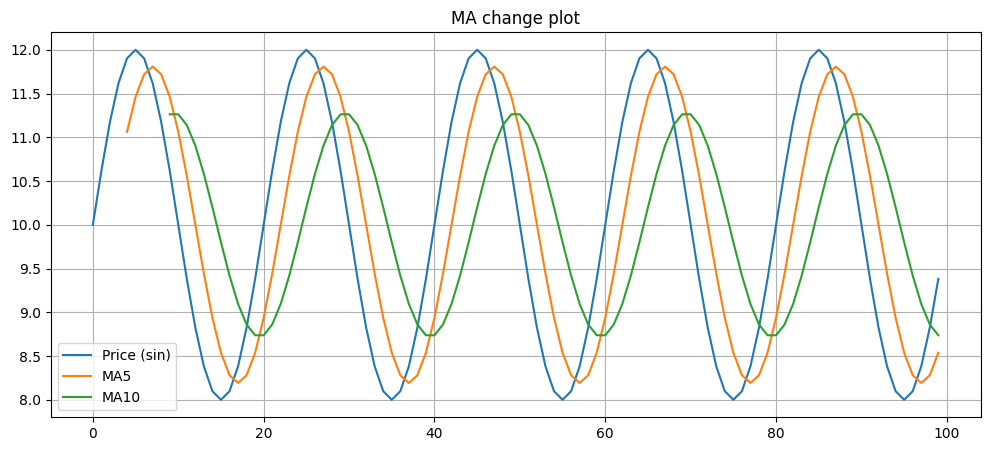

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 构造震荡价格信号
t = np.arange(0, 100, 1)
price = 10 + 2 * np.sin(2 * np.pi * t / 20)  # 周期震荡

df = pd.DataFrame({'price': price}, index=t)
df['ma5'] = df['price'].rolling(5).mean()
df['ma10'] = df['price'].rolling(10).mean()

plt.figure(figsize=(12, 5))
plt.plot(df['price'], label='Price (sin)')
plt.plot(df['ma5'], label='MA5')
plt.plot(df['ma10'], label='MA10')
plt.title('MA change plot')
plt.legend()
plt.grid(True)
plt.show()


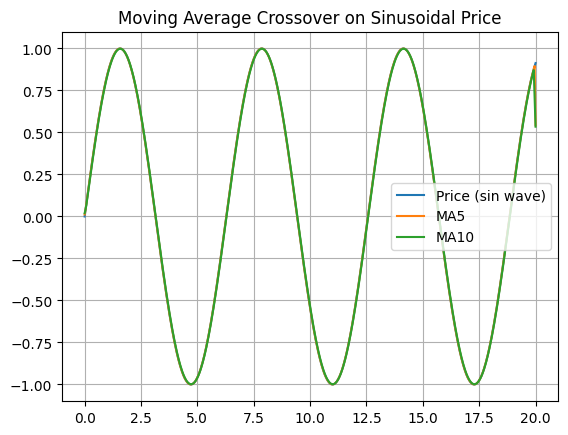

In [23]:
import numpy as np
import matplotlib.pyplot as plt

t = np.linspace(0, 20, 1000)
P = np.sin(t)
MA5 = np.convolve(P, np.ones(5)/5, mode='same')
MA10 = np.convolve(P, np.ones(10)/10, mode='same')

plt.plot(t, P, label='Price (sin wave)')
plt.plot(t, MA5, label='MA5')
plt.plot(t, MA10, label='MA10')
plt.legend()
plt.title("Moving Average Crossover on Sinusoidal Price")
plt.grid(True)
plt.show()
